In [14]:
import os, yaml, sys
import numpy as np
import torch
import h5py
from torchvision import models
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from scipy.io import loadmat
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import create_RDM, compute_dRSA, get_device, decode_matlab_strings, print_wise, get_lagplot_subset, subsample_RDM
from general_utils.regression import static_lagged_linear_regression
from general_utils.plots import truncate_colormap
from image_processing.utils import get_usual_transform
#from image_processing.computational_models import map_image_order_from_ann_to_monkey
device = get_device()

12:54:24 - device being used: mps


Set variables

In [ ]:
from dataclasses import dataclass, field

@dataclass
class Cfg:
    img_size: int = 224
    model_name: str = 'alexnet'
    layer_name: str = 'features.7'
    monkey_name: str = 'paul' 
    date: str = '230204'
    neurons_range: np.ndarray = field(default_factory=lambda: np.arange(10))
    avg_win: int = 10 #ms
    similarity_metric: str = "cosine"
    pkg: str = 'torchvision'
cfg = Cfg()
from general_utils.utils import get_relevant_output_layers
layers = get_relevant_output_layers(cfg.model_name, pkg=cfg.pkg)

Load the raster

In [3]:
rasters_path = f"{paths['livingstone_lab']}/tiziano/data/{cfg.monkey_name}_natraster{cfg.date}.mat"
with h5py.File(rasters_path, "r") as f:
    rasters = f["natraster"][:]      
rasters = rasters.transpose(2, 1, 0)
print(rasters.shape) # channels, time, trials

(383, 400, 4377)


Temporal Smoothing the raster

In [4]:
from data_preprocessing.preprocessing import create_bins, get_firing_rate
bins = create_bins(400, cfg.avg_win)
#neural_signal = rasters[trial_start_int - foreperiod_len:trial_end_int, :].T  # slices the trial from raster
tot_firing_rate = []
for i_trial in range(rasters.shape[2]):
    firing_rate = get_firing_rate(bins, rasters[:,:,i_trial])
    tot_firing_rate.append(firing_rate)
rasters_smooth = np.stack(tot_firing_rate, axis=2)


Compute the RDMs for the raster

In [18]:
RDMs_list =[]
for i_time in range(rasters_smooth.shape[1]):
    RDMs_list.append(create_RDM(rasters_smooth[cfg.neurons_range, i_time, :], metric=cfg.similarity_metric))

In [6]:
idx = np.random.randint(low=0, high=rasters_smooth.shape[2], size=1000)

## RSA

In [ ]:

max_latency = []
all_dRSAs = []
for l in layers[:]:
    print_wise(f"computing layer {l}")
    similarity = []
    try:
        #RDM_mod = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_RDM_meanpool.npz")["arr_0"]
        feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_features_meanpool.npz")["arr_0"]
        # feats = feats[:,randidx]
        RDM_mod = create_RDM(feats.T, metric=cfg.similarity_metric)
        #RDM_mod_ord = subsample_RDM(squareform(RDM_mod), mapping_idx)
        # RDM_mod = squareform(subsample_RDM(squareform(RDM_mod), randidx))
        for i_time in range(len(RDMs_list)):
            #RDM_neu = squareform(subsample_RDM(squareform(RDMs_list[i_time]), randidx))
            RDM_neu = RDMs_list[i_time]
            similarity.append(np.corrcoef(RDM_neu, RDM_mod)[0, 1])
        all_dRSAs.append(similarity)
        max_latency.append(np.argmax(similarity))
        # plt.plot(similarity, label=f"{l} - {max_latency[-1]*cfg.avg_win}")
    except FileNotFoundError:
        print_wise(f"{l} not found")
# plt.legend()
max_latency = np.array(max_latency)*cfg.avg_win

12:23:26 - computing layer features.0
12:23:29 - computing layer features.4
12:23:31 - computing layer features.7
12:23:35 - computing layer features.9
12:23:38 - computing layer features.11
12:23:41 - computing layer classifier.2
12:24:15 - computing layer classifier.5


NameError: name 'all_dRSAs' is not defined

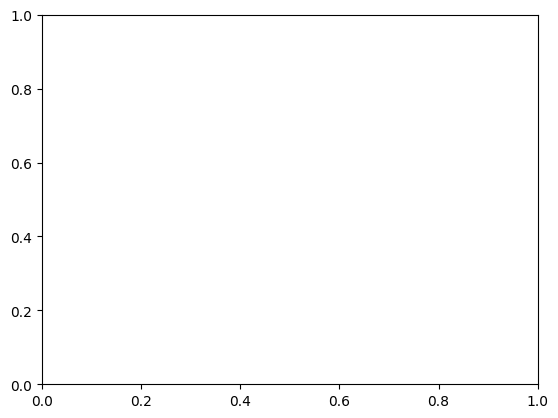

In [ ]:


base_cmap = plt.cm.turbo
cmap = truncate_colormap(base_cmap, 0.10, 0.90)


fig, ax = plt.subplots()
for idx, dRSA in enumerate(all_dRSAs):
    color = cmap(idx / (len(layers) - 1))
    ax.plot(dRSA, label=f"{layers[idx]} - {max_latency[idx]}ms", color=color,  linewidth=2)
ax.legend(fontsize=6)
ax.set_ylabel("RSA correlation")
ax.set_xlabel("time from image onset (ms)")
ax.set_xticks(np.arange(0, len(all_dRSAs[0]), 50//cfg.avg_win));
ax.set_xticklabels(np.arange(0, len(all_dRSAs[0]), 50//cfg.avg_win)*cfg.avg_win);
ax.set_title("Lagged Representational Similarity Analysis")



In [7]:
from image_processing.utils import load_torchvision_model, load_timm_model
from general_utils.utils import get_layer_output_shape
from torchvision.models.feature_extraction import get_graph_node_names
device = get_device()
m = load_timm_model(cfg.model_name, device) if cfg.pkg == 'timm' else load_torchvision_model(cfg.model_name, device)
all_layers = get_graph_node_names(m)
layers_depth = np.array([all_layers[0].index(l)/len(all_layers[0]) for l in layers])


12:45:37 - device being used: mps


Text(0.5, 1.0, 'Correlation RSA peak latency - layer depth')

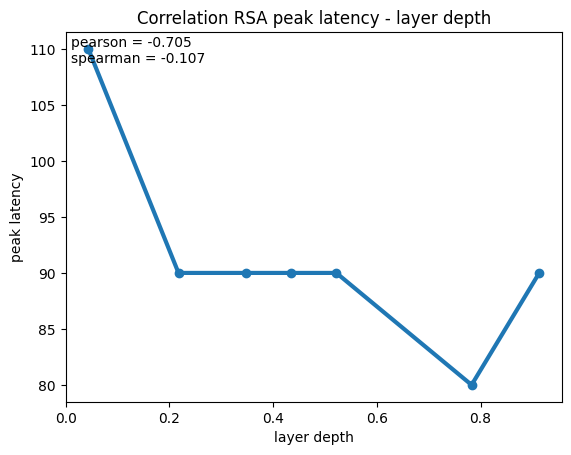

In [191]:
from general_utils.utils import spearman
pearson = np.corrcoef(layers_depth, max_latency)[0,1]
spearman = spearman(np.array(layers_depth), max_latency)
fig, ax = plt.subplots()
ax.plot(layers_depth, max_latency, marker="o", linewidth=3)
ax.set_ylabel("peak latency")
ax.set_xlabel("layer depth")
# Fix: combine your text strings into one
ax.text(0.01, 0.99, f"pearson = {pearson:.3f}\nspearman = {spearman:.3f}", 
        transform=ax.transAxes, 
        verticalalignment='top', 
        horizontalalignment='left')
ax.set_title("Correlation RSA peak latency - layer depth")


 ## LINEAR REGRESSION
 compute linear regression (with the dimensionality reduced features) and check the fit over time

In [ ]:
from general_utils.regression import choose_CV_type, choose_regression_type, evaluate_prediction
def static_lagged_linear_regression(x, y, regression_type='lr', alpha=0.0, cv_type='same', n_splits=5, shuffle=True, max_lag=20, symmetric=False):
    lr_list = []
    if symmetric:
        lags_range = range(max_lag+1)
    else:
        lags_range = range(-max_lag, max_lag+1)
    # end if symmetric:

    x_shifted_tot = x.T
    for tau in range(y.shape[1]):
        y_shifted_tot = y[:,tau,:].T
        CV = choose_CV_type(cv_type, n_splits=n_splits, shuffle=shuffle)
        curr_lr = []
        for train_idx, test_idx in CV.split(x_shifted_tot):
            train_x, train_y = x_shifted_tot[train_idx, :], y_shifted_tot[train_idx, :]
            test_x, test_y = x_shifted_tot[test_idx, :], y_shifted_tot[test_idx, :]
            regression_obj = choose_regression_type(regression_type=regression_type, alpha=alpha)
            regression_obj = regression_obj.fit(train_x, train_y)
            #R2 = regression_obj.score(test_x, test_y) # later add correlation and see if add weights or something else
            avg_corr = evaluate_prediction(test_x, test_y, regression_obj)
            curr_lr.append(avg_corr)
        # end for train_idx, test_idx in CV.split(x_shifted_tot):
        lr_list.append(np.nanmean(curr_lr))  #x_t_shifted_tot, y_t_shifted_tot))
    # end for L in range(-max_lag, max_lag):    
    return lr_list
# EOF




In [19]:

lr_list = []
computed_layers_list = []
for l in layers:
    print_wise(l)
    try:
        feats = np.load(f"{paths['livingstone_lab']}/tiziano/models/{cfg.monkey_name}_{cfg.date}_{cfg.model_name}_{cfg.img_size}_{l}_features_meanpool.npz")["arr_0"]
        # IMPORTANT !!! CREATE PATCH TO AVOID EXTRACTING FEATURES with samples in the rows (and avoid transposing below)
        lr = static_lagged_linear_regression(feats.T, rasters_smooth[cfg.neurons_range,:,:], regression_type="ridge", alpha=1, cv_type="kf") 
        lr_list.append(lr)
        computed_layers_list.append(l)
    except FileNotFoundError:
        print_wise(f"{l} not found")
        pass
max_latency_lr = np.array([np.argmax(lr) for lr in lr_list])*cfg.avg_win

13:01:28 - features.0


KeyboardInterrupt: 

Text(0.5, 1.0, 'lagged linear regression')

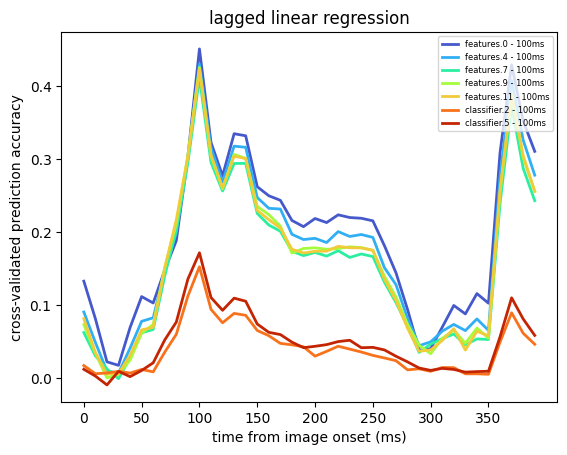

In [12]:
base_cmap = plt.cm.turbo
from matplotlib.colors import LinearSegmentedColormap
def truncate_colormap(cmap, minval=0.1, maxval=0.9, n=256):
    return LinearSegmentedColormap.from_list(
        f"trunc({cmap.name})",
        cmap(np.linspace(minval, maxval, n))
    )
cmap = truncate_colormap(base_cmap, 0.10, 0.90)


fig, ax = plt.subplots()
for idx, dRSA in enumerate(lr_list):
    color = cmap(idx / (len(layers) - 1))
    ax.plot(dRSA, label=f"{layers[idx]} - {max_latency_lr[idx]}ms", color=color,  linewidth=2)
ax.legend(fontsize=6, loc="upper right")
ax.set_ylabel("cross-validated prediction accuracy")
ax.set_xlabel("time from image onset (ms)")
ax.set_xticks(np.arange(0, len(lr_list[0]), 50//cfg.avg_win));
ax.set_xticklabels(np.arange(0, len(lr_list[0]), 50//cfg.avg_win)*cfg.avg_win);
ax.set_title("lagged linear regression")

In [ ]:

pearson = np.corrcoef(layers_depth, max_latency_lr)[0,1]
spearman = spearman(np.array(layers_depth), max_latency_lr)
fig, ax = plt.subplots()
ax.plot(layers_depth, np.array(max_latency_lr)*cfg.avg_win, marker="o", linewidth=3)

# Fix: combine your text strings into one
ax.text(0.01, 0.99, f"pearson = {pearson:.3f}\nspearman = {spearman:.3f}", 
        transform=ax.transAxes, 
        verticalalignment='top', 
        horizontalalignment='left')

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


TypeError: 'numpy.float64' object is not callable